In [1]:
import berreman4x4 as bm
from lmfit import minimize, Parameters, fit_report

bm.settings['ExpmBackend'] = 'tensorflow'
bm.settings['solver'] = 'simple2x2'

# Load data
Load data collected with Sentech Ellipsometer and cut the spectral range (to use Si Aspnes file)

The sample is a ALD grown TiO2 sample (with 400 cycles) on commercially available SiO2 / Si substrate.

In [2]:
tss = bm.SpectraRay.read_psi_delta_file('TiO2_400cycles.txt').loc[400:800]

# Build the model

In [3]:
sr = bm.SpectraRay('c:/sentech/spectraray4/mat/')
Si = bm.IsotropicMaterial(sr.loadDispersionTable('Semiconductor\\IV\\Si_Aspnes.mat'))

def fit_function(params, lbda=None, psi=None, delta=None):
    SiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(params['SiO2_n0'], 
                                                    params['SiO2_n1'], 
                                                    params['SiO2_n2'], 
                                                    params['SiO2_k0'], 
                                                    params['SiO2_k1'], 
                                                    params['SiO2_k2']))
    TiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(params['TiO2_n0'], 
                                                    params['TiO2_n1'], 
                                                    params['TiO2_n2'], 
                                                    params['TiO2_k0'], 
                                                    params['TiO2_k1'], 
                                                    params['TiO2_k2']))
    
    Front = bm.IsotropicMaterial(bm.DispersionLess(1))  # Air
    Layer = [bm.Layer(TiO2, params['TiO2_d']), 
             bm.Layer(SiO2, params['SiO2_d'])]
    S = bm.Structure(Front, Layer, Si)
    
    result = S.evaluate(lbda, 70)
    
    resid_rhor = psi - result.rho.real
    resid_rhoi = delta - result.rho.imag
    return np.concatenate((resid_rhor, resid_rhoi))

params = Parameters()
params.add('SiO2_n0', value=1.452, min=-100, max=100, vary=False)
params.add('SiO2_n1', value=36.0, min=-40000, max=40000, vary=False)
params.add('SiO2_n2', value=0, min=-40000, max=40000, vary=False)
params.add('SiO2_k0', value=0, min=-100, max=100, vary=False)
params.add('SiO2_k1', value=0, min=-40000, max=40000, vary=False)
params.add('SiO2_k2', value=0, min=-40000, max=40000, vary=False)
params.add('SiO2_d', value=276.36, min=0, max=40000, vary=False)

params.add('TiO2_n0', value=2.236, min=-100, max=100, vary=True)
params.add('TiO2_n1', value=451, min=-40000, max=40000, vary=True)
params.add('TiO2_n2', value=251, min=-40000, max=40000, vary=True)
params.add('TiO2_k0', value=0, min=-100, max=100, vary=False)
params.add('TiO2_k1', value=0, min=-40000, max=40000, vary=False)
params.add('TiO2_k2', value=0, min=-40000, max=40000, vary=False)

params.add('TiO2_d', value=20, min=0, max=40000, vary=True)

In [5]:
ρ = tss.apply(lambda x: np.tan(x[0] * np.pi / 180) * np.exp(-1j * x[1] * np.pi / 180), axis=1)
out = minimize(fit_function, params, args=(ρ.index.to_numpy(), ρ.values.real, ρ.values.imag), method='leastsq')
out

# Show fit

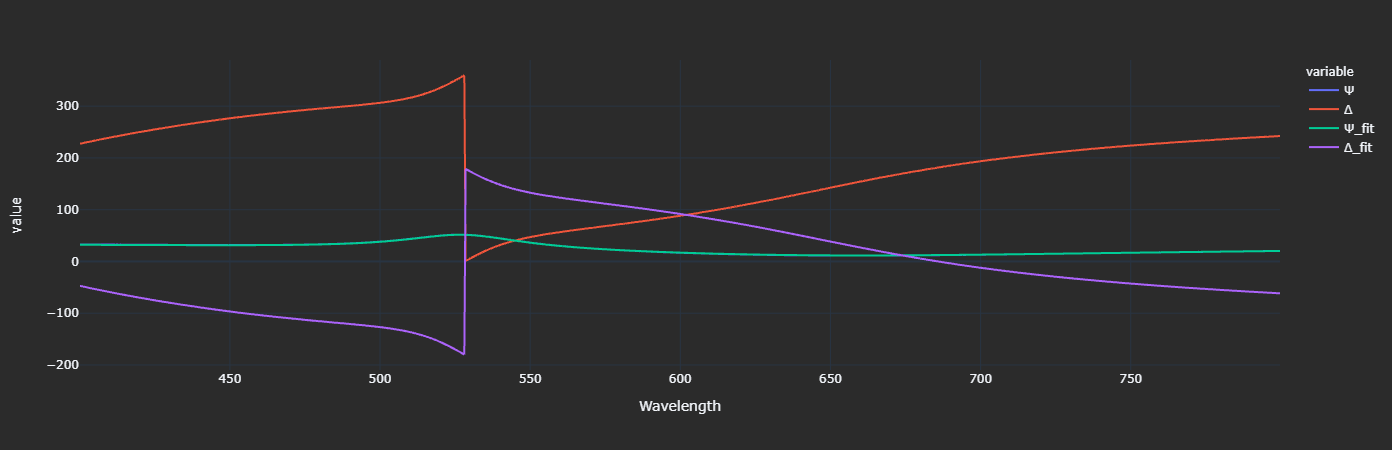

In [7]:
SiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(out.params['SiO2_n0'], out.params['SiO2_n1'], out.params['SiO2_n2'],
                                                out.params['SiO2_k0'], out.params['SiO2_k1'], out.params['SiO2_k2']))

TiO2 = bm.IsotropicMaterial(bm.DispersionCauchy(out.params['TiO2_n0'], 
                                                out.params['TiO2_n1'], 
                                                out.params['TiO2_n2'], 
                                                out.params['TiO2_k0'], 
                                                out.params['TiO2_k1'], 
                                                out.params['TiO2_k2']))


Front = bm.IsotropicMaterial(bm.DispersionLess(1))  # Air
Layer = [bm.Layer(TiO2, out.params['TiO2_d']),
         bm.Layer(SiO2, out.params['SiO2_d'])]
S = bm.Structure(Front, Layer, Si)

fit_result = S.evaluate(tss.index.to_numpy(), 70)

pd.concat([tss, 
           pd.DataFrame({'Ψ_fit': fit_result.psi,
                        'Δ_fit': fit_result.delta}, 
                        index=tss.index)]
         ).plot()